In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
import re
import os
import time
from datetime import datetime
import seaborn as sns

In [8]:
df = pd.read_csv("readings.csv", on_bad_lines='error')
display(df.shape, df.head())

(2500, 6)

,cpu_speed,volts,fan_speed,cpu_pct,load_avg,temp
0,1.500013,0.7200,3019.0,5.1,0.577148,46.6
1,2.400024,0.8806,3020.0,23.3,0.577148,46.6
2,2.400020,0.8806,3021.0,1.9,0.577148,47.2
3,2.400020,0.8806,3020.0,1.9,0.577148,47.2
4,2.400030,0.8806,3021.0,1.0,0.577148,46.6


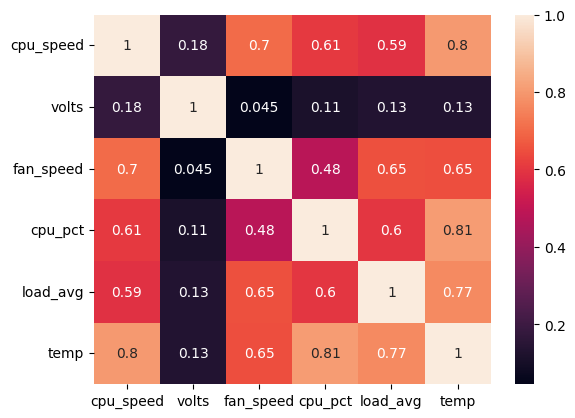

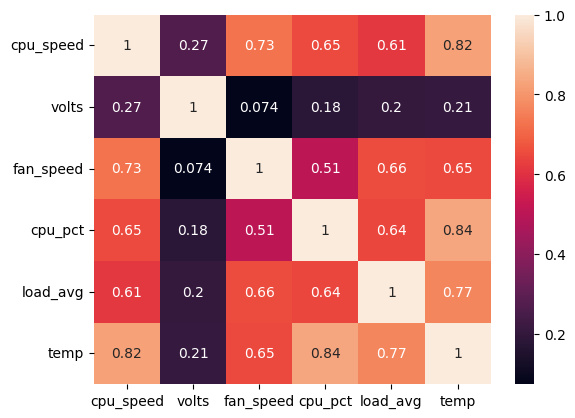

In [9]:
# 5-point rolling average to smooth noise
df_adjusted = df.copy()
rolling_cols = ['cpu_speed', 'volts', 'fan_speed', 'cpu_pct']
df_adjusted[rolling_cols] = df_adjusted[rolling_cols].rolling(window=5).mean()

sns.heatmap(df.corr(), annot=True)
plt.show()
sns.heatmap(df_adjusted.corr(), annot=True)
plt.show()

# Tensorflow: Multiple variable linear regression

In [14]:
import tensorflow as tf

def plot_preds(x, y, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

df_data = df_adjusted.dropna(how="any")

feature_cols = ["cpu_pct", "load_avg", "cpu_speed", "fan_speed"]

# Separate the feature data from the target data we want to predict.
X = df_data[feature_cols]
y = df_data.temp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
display(f"Train length: {len(X_train)}, Test length: {len(X_test)}")

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())
    
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics=[tf.keras.metrics.R2Score()]
)

history = linear_model.fit(
    X_train,
    y_train,
    epochs=20,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

linear_model.evaluate(X_test, y_test, verbose=1)


'Train length: 1996, Test length: 500'

[[1.1053106e+01 8.0133021e-01 1.9243003e+00 1.6756168e+03]]
First example: [[  11.24    1.37    2.4  3040.6 ]]

Normalized: [[0.01 1.03 1.11 0.91]]
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 0.5945 - r2_score: 0.8892


[0.5944997072219849, 0.8891550898551941]

# Tensorflow: Neural network regression

In [15]:
def plot_loss(history, ylim=10):
    plt.clf()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, ylim])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

def plot_scatter(x, y, x_label, y_label):
    plt.clf()
    plt.axes(aspect='equal')
    plt.scatter(x, y, alpha=0.2)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def plot_hist(data, x_label, y_label):
    plt.clf()
    plt.hist(data, bins=25)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show() 

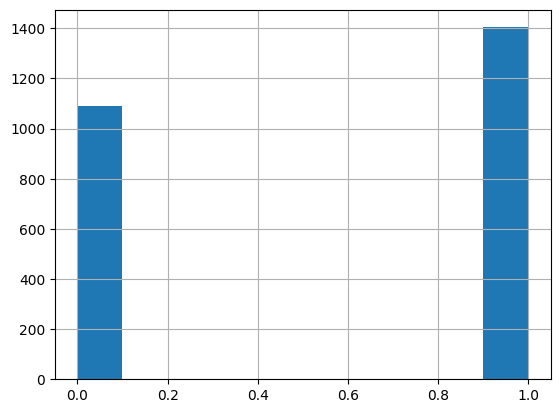

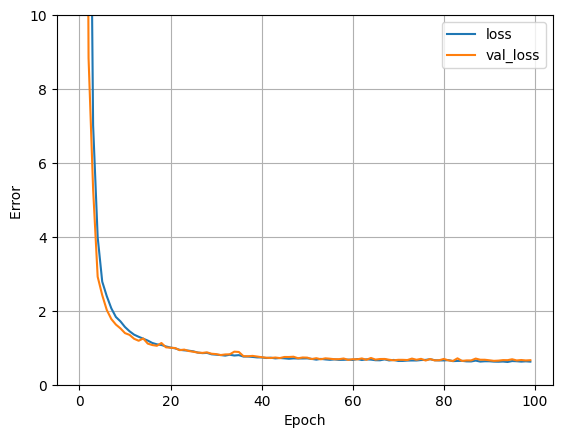

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 0.6456 - r2_score: 0.8632


[0.6456494331359863, 0.8632128834724426]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


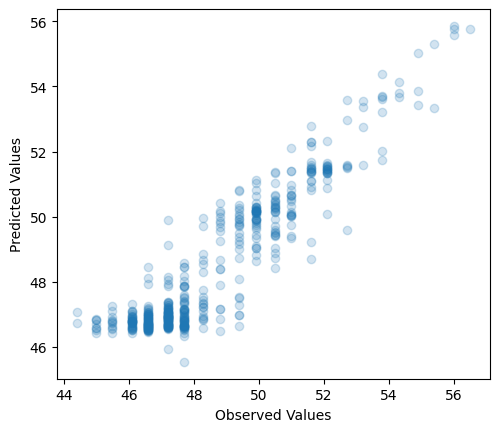

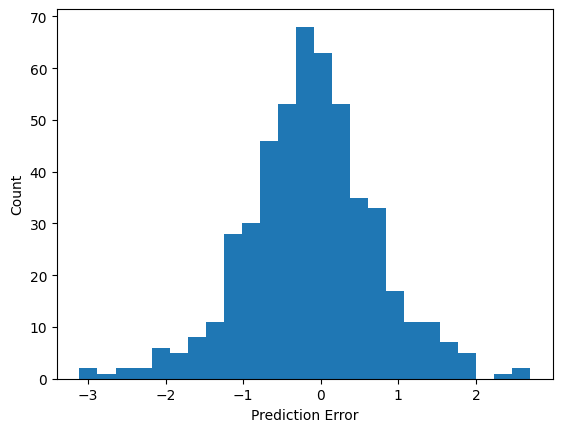

In [16]:
import tensorflow as tf

# Convert fan speed into an on/off indicator.
df_data["fan_state"] = df_data.fan_speed.apply(lambda x: 1 if x > 0 else 0)
plt.clf()
df_data.fan_state.hist()
plt.show()

feature_cols = ["cpu_pct", "load_avg", "cpu_speed", "fan_speed"]

# Separate the feature data from the target data we want to predict.
X = df_data[feature_cols]
y = df_data.temp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
    
dnn_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

dnn_model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=[tf.keras.metrics.R2Score()]
)

history = dnn_model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

plot_loss(history)
plt.show()

display(dnn_model.evaluate(X_test, y_test, verbose=1))

y_pred = dnn_model.predict(X_test).flatten()

plot_scatter(y_test, y_pred, 'Observed Values', 'Predicted Values')
plot_hist(y_pred-y_test, "Prediction Error", "Count")

# Tensorflow: Neural network classification

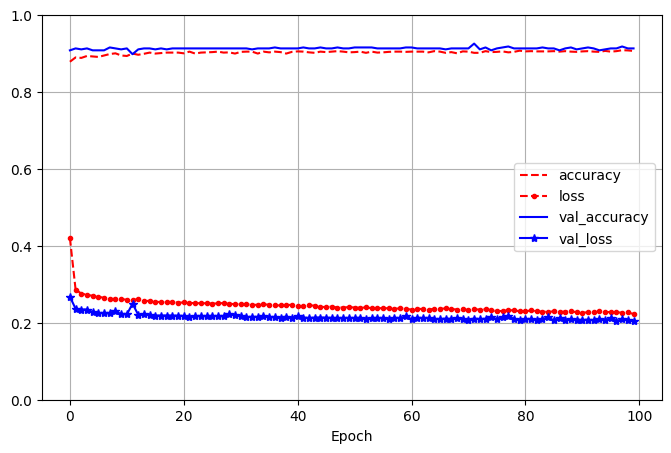

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.8920 - loss: 0.2646


[0.26458755135536194, 0.8920000195503235]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


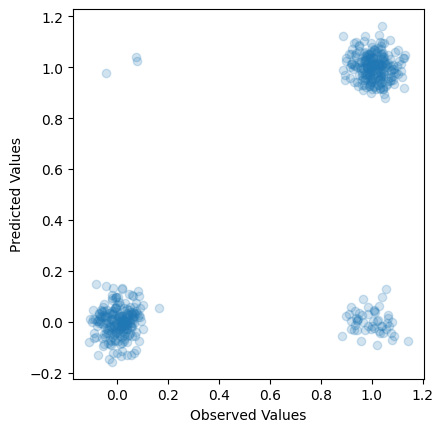

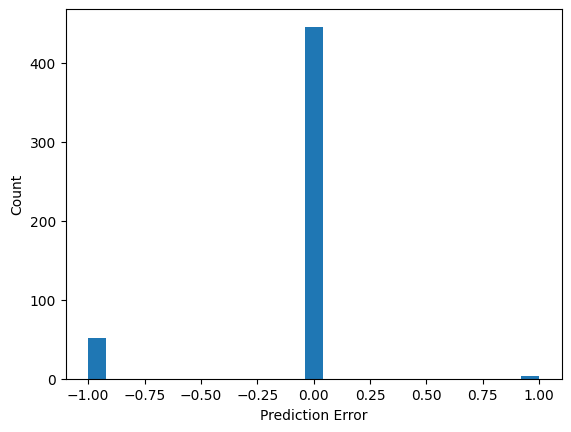

In [17]:
# see https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/ch10.html#id159
def rand_jitter(arr):
    stdev = .05 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

feature_cols = ["load_avg", "temp"]
# feature_cols = ["cpu_pct", "load_avg", "cpu_speed", "temp"]

# Separate the feature data from the target data we want to predict.
X = df_data[feature_cols]
y = df_data.fan_state

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
    
dnn_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
    #tf.keras.layers.Dense(2, activation="softmax") # use this for "sparse labels"
])

# dnn_model.compile(loss='sparse_categorical_crossentropy', # use this for "sparse labels"
#                   optimizer="sgd",
#                   metrics=["accuracy"]
# )
dnn_model.compile(loss='binary_crossentropy',
                  optimizer="adam",
                  metrics=["accuracy"]
)

history = dnn_model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

pd.DataFrame(history.history).plot(
    figsize=(8, 5), ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

display(dnn_model.evaluate(X_test, y_test, verbose=1))

y_proba = dnn_model.predict(X_test)
# y_pred = y_proba.argmax(axis=-1) # use this for "sparse labels"
y_pred = np.array([1 if x >= 0.5 else 0 for x in tf.squeeze(y_proba)])

plot_scatter(rand_jitter(y_test), rand_jitter(y_pred), 'Observed Values', 'Predicted Values')
plot_hist(y_pred-y_test, 'Prediction Error', 'Count')